<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/Transformer_vs_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install japanize-matplotlib -q
import matplotlib.pyplot as plt
import japanize_matplotlib  # これだけで日本語OK
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の豆腐対策

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


[Device] cuda
[INFO] data: (9000, 3) | train_T: 4500 val_T: 6750


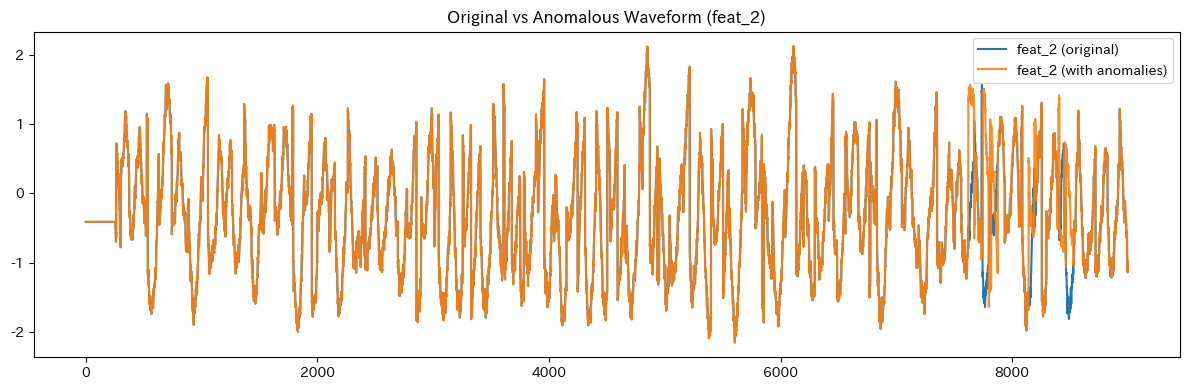

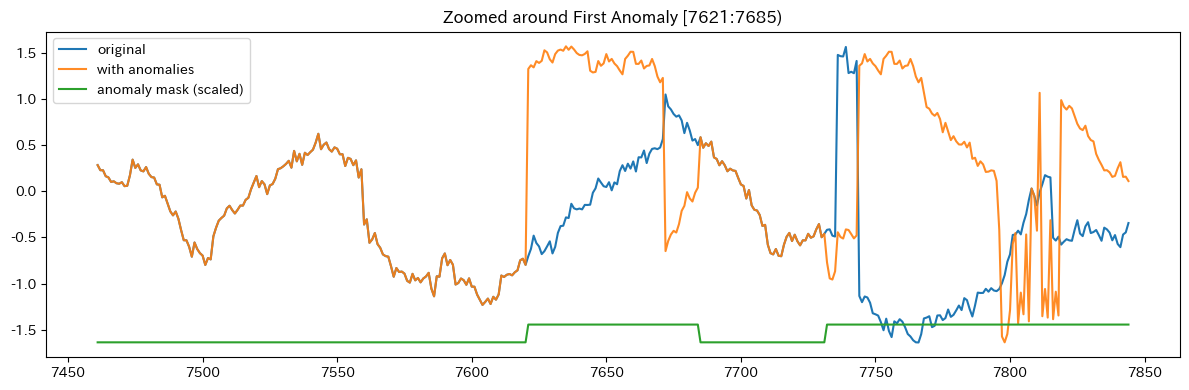

[lstm] epoch 001 train 0.958570 val 1.128763
[lstm] epoch 002 train 0.950898 val 1.122969
[lstm] epoch 003 train 0.943303 val 1.114844
[lstm] epoch 004 train 0.937734 val 1.110206
[lstm] epoch 005 train 0.922150 val 1.100313
[lstm] epoch 006 train 0.915336 val 1.094710
[lstm] epoch 007 train 0.891659 val 1.059154
[lstm] epoch 008 train 0.874771 val 1.044706
[lstm] epoch 009 train 0.865934 val 1.046740
[lstm] epoch 010 train 0.861064 val 1.041429
[lstm] epoch 011 train 0.855850 val 1.044302
[lstm] epoch 012 train 0.852009 val 1.036974
[lstm] epoch 013 train 0.849539 val 1.035149
[lstm] epoch 014 train 0.845600 val 1.035378
[lstm] epoch 015 train 0.838150 val 1.009082
[lstm] epoch 016 train 0.819343 val 0.971679
[lstm] epoch 017 train 0.804527 val 0.964667
[lstm] epoch 018 train 0.757423 val 0.929767
[lstm] epoch 019 train 0.745019 val 0.871559
[lstm] epoch 020 train 0.685209 val 0.824332
[lstm] epoch 021 train 0.653295 val 0.826869
[lstm] epoch 022 train 0.675607 val 0.895583
[lstm] epo

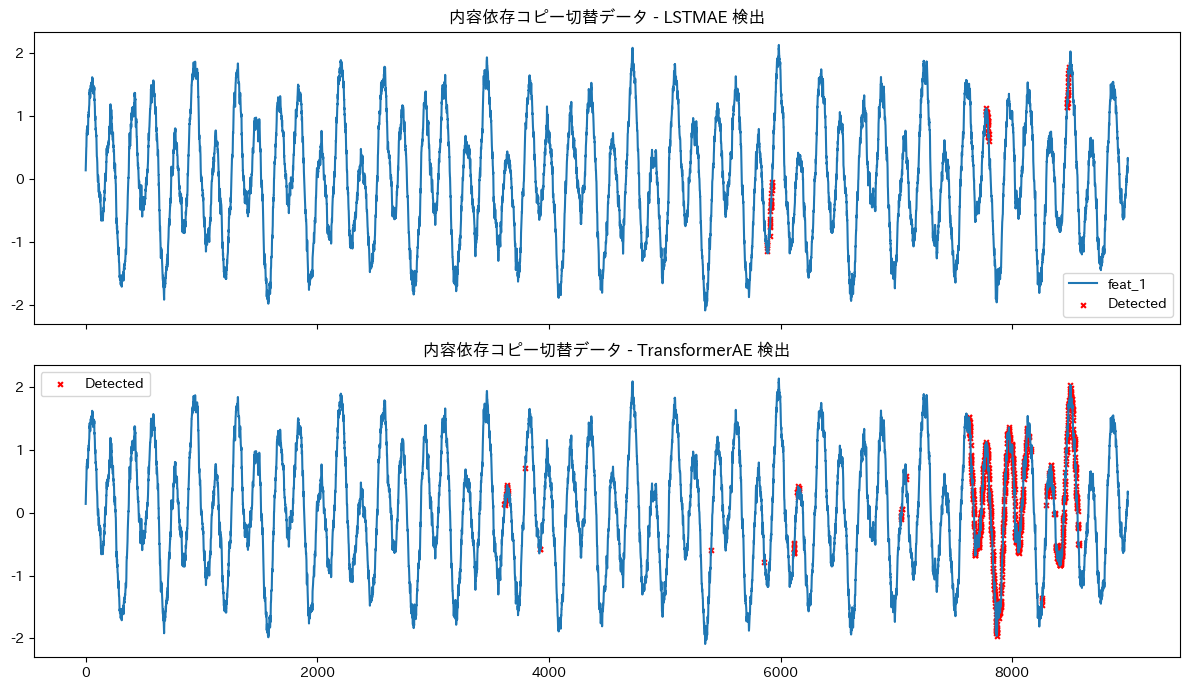

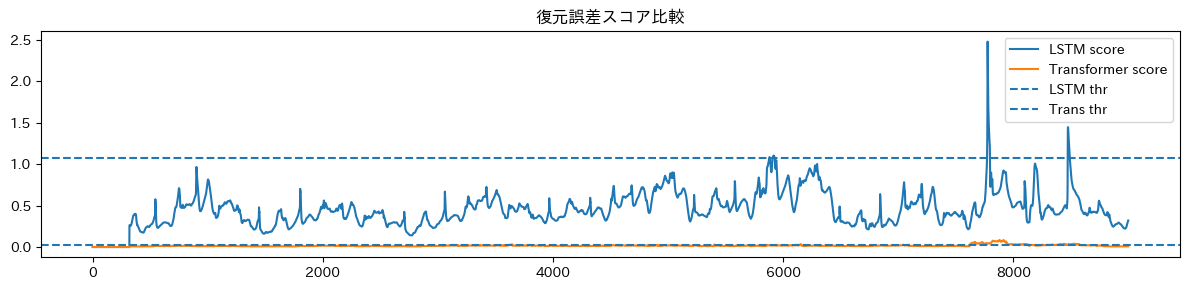

[LSTM] precision=0.657 recall=0.107 f1=0.184 PR-AUC=0.241
[Transformer] precision=0.438 recall=0.842 f1=0.576 PR-AUC=0.501
[DONE]


In [14]:
"""
LSTMAEとTransformerAEの比較（1セル/コピペ用・PyTorch+Colab）
- 追加: LSTMが苦手でTransformerが有利になりやすい「*コンテンツ依存の長距離コピー切替*」データを用意
- 先頭でオリジナル vs 異常入りの波形も表示
- 時間ベース分割（前半=学習, 中盤=検証, 後半=評価）でしきい値汚染を回避
"""

# ===== Imports =====
import math, random
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ===== Reproducibility & Device =====
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] {device}")

# ===== Configs =====
@dataclass
class Config:
    window_size: int = 320
    stride: int = 1
    latent_dim: int = 16       # LSTMはボトルネックを小さめに（局所記憶に依存させる）
    batch_size: int = 128
    epochs: int = 35
    val_ratio: float = 0.2     # 未使用（時間分割）
    threshold_percentile: float = 99.0
    patience: int = 6
    lr: float = 1e-3

@dataclass
class TConfig:
    d_model: int = 64
    nhead: int = 4
    num_layers_enc: int = 2
    num_layers_dec: int = 2
    dropout: float = 0.2

# ===== Dataset A: 従来（長距離依存の破れ） =====
def make_long_lag_dependency_series(n_points=9000, base_period=220, delay_normal=160,
                                    noise_std=0.07, n_anom_segments=8, anom_len=80):
    t = np.arange(n_points)
    base = 1.2*np.sin(2*np.pi*t/base_period) + 0.6*np.sin(2*np.pi*t/(base_period*3)+0.3)
    ar = np.zeros(n_points)
    for i in range(1,n_points): ar[i] = 0.85*ar[i-1] + np.random.normal(0, noise_std)
    feat1 = base + ar
    feat2_norm = np.roll(feat1, delay_normal) + np.random.normal(0, noise_std*0.5, size=n_points)
    feat2_norm[:delay_normal] = feat2_norm[delay_normal]
    feat2_anom = feat2_norm.copy(); y_true = np.zeros(n_points, dtype=int)
    train_T = int(n_points*0.5); val_T = int(n_points*0.75)
    segs = []
    for _ in range(n_anom_segments):
        start = int(np.random.randint(val_T+50, n_points-anom_len-1)); end_ex = min(start+anom_len, n_points)
        y_true[start:end_ex] = 1; segs.append((start,end_ex))
        mode = np.random.choice(["wrong_delay","invert","shuffle"], p=[0.5,0.3,0.2])
        if mode=="wrong_delay":
            bad_delay = int(np.random.choice([40, 220])); rolled = np.roll(feat1, bad_delay)
            feat2_anom[start:end_ex] = rolled[start:end_ex]
        elif mode=="invert":
            feat2_anom[start:end_ex] = -feat2_anom[start:end_ex]
        else:
            seg = feat2_anom[start:end_ex].copy(); np.random.shuffle(seg); feat2_anom[start:end_ex] = seg
    dfN = pd.DataFrame({"feat_1": feat1, "feat_2": feat2_norm, "feat_3": np.convolve(feat1, np.ones(15)/15, 'same')})
    dfA = pd.DataFrame({"feat_1": feat1, "feat_2": feat2_anom, "feat_3": np.convolve(feat1, np.ones(15)/15, 'same')})
    return dfN, dfA, y_true, segs, train_T, val_T

# ===== Dataset B: 新規（内容に応じて遠い過去を*動的に選択*する） =====
#  → 各時刻 t でセレクタ s_t が {L1,L2,L3} からラグを切替。
#  → s_t は feat1 の局所符号や移動平均など「内容」に依存して頻繁に変わる。
#  → 異常では"間違ったラグ"でコピー or セグメントシャッフル。
#  → ウィンドウ内で多種の遠距離対応が混在 → 自己注意で有利。

def make_content_switched_copy_series(n_points=9000, lags=(32, 128, 256), switch_every=8,
                                      noise_std=0.06, n_anom_segments=10, anom_len=64):
    t = np.arange(n_points)
    base = 1.1*np.sin(2*np.pi*t/180) + 0.7*np.sin(2*np.pi*t/420 + 0.2)
    ar = np.zeros(n_points)
    for i in range(1,n_points): ar[i] = 0.9*ar[i-1] + np.random.normal(0, noise_std)
    feat1 = base + ar

    # セレクタ s_t を内容から決める（符号×移動平均×周期で3状態を作る）
    ma = np.convolve(feat1, np.ones(21)/21, mode='same')
    phase = np.sin(2*np.pi*t/300)
    raw = np.stack([np.sign(feat1), np.sign(ma), np.sign(phase)], axis=1)  # (-1,0,1)
    s = (raw[:,0]>0).astype(int) + (raw[:,1]>0).astype(int) + (raw[:,2]>0).astype(int)  # 0..3
    s = np.clip(s, 0, 2)  # 3→2 に丸める

    # セレクタを一定間隔ごとにブロック化して頻繁に切替
    for i in range(0, n_points, switch_every):
        s[i:i+switch_every] = s[i]

    L1, L2, L3 = lags
    maxL = max(lags)
    feat2_norm = np.zeros(n_points)
    for i in range(n_points):
        L = L1 if s[i]==0 else (L2 if s[i]==1 else L3)
        j = i - L
        if j < 0: j = 0
        feat2_norm[i] = feat1[j]
    feat2_norm += np.random.normal(0, noise_std*0.5, size=n_points)
    feat2_norm[:maxL] = feat2_norm[maxL]

    feat2_anom = feat2_norm.copy(); y_true = np.zeros(n_points, dtype=int)
    train_T = int(n_points*0.5); val_T = int(n_points*0.75)
    segs = []
    for _ in range(n_anom_segments):
        start = int(np.random.randint(val_T+50, n_points-anom_len-1)); end_ex = min(start+anom_len, n_points)
        y_true[start:end_ex] = 1; segs.append((start,end_ex))
        mode = np.random.choice(["wrong_L","shuffle"], p=[0.7,0.3])
        if mode=="wrong_L":
            # 正しいラグと違うラグへすり替え（s_tをずらす）
            wrong = (s[start:end_ex] + np.random.choice([1,2])) % 3
            out = np.zeros(end_ex-start)
            for k,idx in enumerate(range(start,end_ex)):
                L = L1 if wrong[k]==0 else (L2 if wrong[k]==1 else L3)
                j = idx - L
                if j<0: j=0
                out[k] = feat1[j]
            feat2_anom[start:end_ex] = out
        else:
            seg = feat2_anom[start:end_ex].copy(); np.random.shuffle(seg); feat2_anom[start:end_ex] = seg

    dfN = pd.DataFrame({"feat_1": feat1, "feat_2": feat2_norm, "feat_3": ma})
    dfA = pd.DataFrame({"feat_1": feat1, "feat_2": feat2_anom, "feat_3": ma})
    return dfN, dfA, y_true, segs, train_T, val_T

# ===== Original vs Anomalous plot =====
def plot_original_vs_anomalous(df_norm, df_anom, y_true, segs, col="feat_2"):
    plt.figure(figsize=(12,4))
    plt.title(f"Original vs Anomalous Waveform ({col}) - Full Length")
    plt.plot(df_norm.index, df_norm[col].values, label=f"{col} (original)")
    plt.plot(df_anom.index, df_anom[col].values, label=f"{col} (with anomalies)", alpha=0.9)
    plt.legend(); plt.tight_layout(); plt.show()
    if segs:
        s,e = segs[0]; pad = 160; a=max(0,s-pad); b=min(len(df_norm), e+pad)
        plt.figure(figsize=(12,4))
        plt.title(f"Zoomed around First Anomaly [{s}:{e})")
        plt.plot(range(a,b), df_norm[col].values[a:b], label="original")
        plt.plot(range(a,b), df_anom[col].values[a:b], label="with anomalies", alpha=0.9)
        ymin, ymax = df_anom[col].values[a:b].min(), df_anom[col].values[a:b].max()
        mask = y_true[a:b]*(ymax-ymin)*0.06 + ymin
        plt.plot(range(a,b), mask, label="anomaly mask (scaled)")
        plt.legend(); plt.tight_layout(); plt.show()

# ===== Windowing =====
def make_windows(X: np.ndarray, window_size: int, stride: int):
    T,F = X.shape; ws=[]; ends=[]
    for st in range(0, T-window_size+1, stride):
        ed=st+window_size; ws.append(X[st:ed]); ends.append(ed-1)
    return np.stack(ws,0), np.array(ends)

def windows_to_pointwise(scores: np.ndarray, n_points: int, end_indices: np.ndarray):
    ps = np.zeros(n_points); ct = np.zeros(n_points)
    for s,t in zip(scores, end_indices): ps[t]+=s; ct[t]+=1
    nz = ct>0; ps[nz]/=ct[nz]; return ps

# ===== Dataset wrapper =====
class WindowDataset(Dataset):
    def __init__(self, Xw): self.Xw=Xw.astype(np.float32)
    def __len__(self): return self.Xw.shape[0]
    def __getitem__(self,i): return torch.from_numpy(self.Xw[i])

# ===== Models =====
class LSTMAutoencoder(nn.Module):
    def __init__(self, timesteps, n_features, latent_dim):
        super().__init__(); self.timesteps=timesteps
        self.e1=nn.LSTM(n_features,64,batch_first=True); self.drp1=nn.Dropout(0.2)
        self.e2=nn.LSTM(64,latent_dim,batch_first=True)
        self.d1=nn.LSTM(latent_dim,latent_dim,batch_first=True); self.drp2=nn.Dropout(0.2)
        self.d2=nn.LSTM(latent_dim,64,batch_first=True); self.out=nn.Linear(64,n_features)
    def forward(self,x):
        x,_=self.e1(x); x=self.drp1(x); _,(h,_) = self.e2(x); z=h[-1]
        z=z.unsqueeze(1).repeat(1,self.timesteps,1); y,_=self.d1(z); y=self.drp2(y); y,_=self.d2(y)
        return self.out(y)

class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=10000):
        super().__init__(); pe=torch.zeros(max_len,d_model)
        pos=torch.arange(0,max_len).unsqueeze(1).float()
        div=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(pos*div); pe[:,1::2]=torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self,x): return x + self.pe[:,:x.size(1),:]

class TransformerAutoencoder(nn.Module):
    def __init__(self, timesteps, n_features, cfg: TConfig):
        super().__init__(); self.timesteps=timesteps
        self.inp=nn.Linear(n_features, cfg.d_model); self.pe=PositionalEncoding(cfg.d_model)
        el=nn.TransformerEncoderLayer(d_model=cfg.d_model,nhead=cfg.nhead,dropout=cfg.dropout,batch_first=True)
        self.enc=nn.TransformerEncoder(el, num_layers=cfg.num_layers_enc)
        self.q = nn.Parameter(torch.zeros(1,timesteps,cfg.d_model))
        dl=nn.TransformerDecoderLayer(d_model=cfg.d_model,nhead=cfg.nhead,dropout=cfg.dropout,batch_first=True)
        self.dec=nn.TransformerDecoder(dl, num_layers=cfg.num_layers_dec)
        self.out=nn.Linear(cfg.d_model, n_features); self.drop=nn.Dropout(cfg.dropout)
        nn.init.normal_(self.q, std=0.02)
    def forward(self,x):
        x=self.inp(x); x=self.pe(x); mem=self.enc(self.drop(x))
        q=self.q.expand(x.size(0),-1,-1); q=self.pe(q)
        y=self.dec(tgt=self.drop(q), memory=mem)
        return self.out(y)

# ===== Train/Eval =====
@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval(); total=n=0.0
    for xb in loader:
        xb=xb.to(device); yb=model(xb); loss=criterion(yb, xb)
        total+=loss.item()*xb.size(0); n+=xb.size(0)
    return total/max(1,n)

def train_epoch(model, loader, opt, criterion, clip=1.0):
    model.train(); total=n=0.0
    for xb in loader:
        xb=xb.to(device); opt.zero_grad(); yb=model(xb); loss=criterion(yb, xb)
        loss.backward();
        if clip is not None: nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step(); total+=loss.item()*xb.size(0); n+=xb.size(0)
    return total/max(1,n)

@torch.no_grad()
def reconstruction_errors(model, Xw, batch_size=512):
    dl=DataLoader(WindowDataset(Xw), batch_size=batch_size, shuffle=False)
    model.eval(); errs=[]
    for xb in dl:
        xb=xb.to(device); yb=model(xb)
        mse=torch.mean((xb-yb)**2, dim=(1,2)); errs.append(mse.cpu().numpy())
    return np.concatenate(errs,0)

# ===== Fit/Detect with time split =====
def fit_detect_time_split(df: pd.DataFrame, cfg: Config, model_name: str, tcfg: Optional[TConfig], train_T: int, val_T: int):
    values=df.values.astype('float32'); scaler=StandardScaler(); Xn=scaler.fit_transform(values)
    Xw, ends = make_windows(Xn, cfg.window_size, cfg.stride)
    train_mask = ends < train_T; val_mask = (ends>=train_T)&(ends<val_T)
    Xtr,Xva = Xw[train_mask], Xw[val_mask]
    dl_tr=DataLoader(WindowDataset(Xtr), batch_size=cfg.batch_size, shuffle=True)
    dl_va=DataLoader(WindowDataset(Xva), batch_size=cfg.batch_size, shuffle=False)
    model = LSTMAutoencoder(cfg.window_size, values.shape[1], cfg.latent_dim).to(device) if model_name=='lstm' \
            else TransformerAutoencoder(cfg.window_size, values.shape[1], tcfg).to(device)
    opt=torch.optim.Adam(model.parameters(), lr=cfg.lr); crit=nn.MSELoss()
    best=float('inf'); best_state=None; noimp=0
    for ep in range(1, cfg.epochs+1):
        tr=train_epoch(model, dl_tr, opt, crit); va=eval_epoch(model, dl_va, crit)
        print(f"[{model_name}] epoch {ep:03d} train {tr:.6f} val {va:.6f}")
        if va<best-1e-6: best, best_state, noimp = va, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
        else: noimp+=1
        if noimp>=cfg.patience: print(f"[{model_name}] early stopping"); break
    if best_state is not None: model.load_state_dict(best_state)
    va_err=reconstruction_errors(model, Xva); thr=float(np.percentile(va_err, cfg.threshold_percentile))
    all_err=reconstruction_errors(model, Xw)
    point_scores=windows_to_pointwise(all_err, len(df), ends); point_pred=(point_scores>thr).astype(int)
    return {'model':model,'threshold':thr,'point_scores':point_scores,'point_pred':point_pred}

# ===== Compare plots & metrics =====
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

def plot_original_vs_anomalous(df_norm, df_anom, y_true, segs, col="feat_2"):
    plt.figure(figsize=(12,4)); plt.title(f"Original vs Anomalous Waveform ({col})")
    plt.plot(df_norm.index, df_norm[col], label=f"{col} (original)")
    plt.plot(df_anom.index, df_anom[col], label=f"{col} (with anomalies)", alpha=0.9)
    plt.legend(); plt.tight_layout(); plt.show()

    if segs:
        s,e = segs[0]; pad=160; a=max(0,s-pad); b=min(len(df_norm), e+pad)
        plt.figure(figsize=(12,4)); plt.title(f"Zoomed around First Anomaly [{s}:{e})")
        plt.plot(range(a,b), df_norm[col].values[a:b], label='original')
        plt.plot(range(a,b), df_anom[col].values[a:b], label='with anomalies', alpha=0.9)
        ymin,ymax = df_anom[col].values[a:b].min(), df_anom[col].values[a:b].max()
        mask = y_true[a:b]*(ymax-ymin)*0.06 + ymin
        plt.plot(range(a,b), mask, label='anomaly mask (scaled)')
        plt.legend(); plt.tight_layout(); plt.show()

def plot_compare(df, y_true, res_lstm, res_trans, title_prefix='内容依存コピー切替データ'):
    fig,axes = plt.subplots(2,1,figsize=(12,7), sharex=True)
    axes[0].set_title(f"{title_prefix} - LSTMAE 検出"); axes[0].plot(df.index, df.iloc[:,0], label=df.columns[0])
    idx=np.where(res_lstm['point_pred']==1)[0];
    if len(idx): axes[0].scatter(idx, df.iloc[idx,0], s=12, marker='x', label='Detected',color="red")
    axes[0].legend()

    axes[1].set_title(f"{title_prefix} - TransformerAE 検出"); axes[1].plot(df.index, df.iloc[:,0])
    idx=np.where(res_trans['point_pred']==1)[0];
    if len(idx): axes[1].scatter(idx, df.iloc[idx,0], s=12, marker='x', label='Detected',color="red")
    axes[1].legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,3)); plt.title('復元誤差スコア比較')
    plt.plot(res_lstm['point_scores'], label='LSTM score'); plt.plot(res_trans['point_scores'], label='Transformer score')
    plt.axhline(res_lstm['threshold'], linestyle='--', label='LSTM thr'); plt.axhline(res_trans['threshold'], linestyle='--', label='Trans thr')
    plt.legend(); plt.tight_layout(); plt.show()

    for name,res in [('LSTM',res_lstm), ('Transformer',res_trans)]:
        p,r,f,_ = precision_recall_fscore_support(y_true, res['point_pred'], average='binary', zero_division=0)
        ap = average_precision_score(y_true, res['point_scores'])
        print(f"[{name}] precision={p:.3f} recall={r:.3f} f1={f:.3f} PR-AUC={ap:.3f}")

# ===== RUN =====
cfg = Config(); tcfg = TConfig()

# ★ データセットを選択 ★
MODE = 'switch'  # 'switch' (Transformer有利) / 'longlag'（従来）

if MODE=='switch':
    dfN, df, y_true, segs, train_T, val_T = make_content_switched_copy_series()
    title = '内容依存コピー切替データ'
else:
    dfN, df, y_true, segs, train_T, val_T = make_long_lag_dependency_series()
    title = '長距離依存の破れデータ'

print('[INFO] data:', df.shape, '| train_T:', train_T, 'val_T:', val_T)

# まずオリジナル vs 異常入り
plot_original_vs_anomalous(dfN, df, y_true, segs, col='feat_2')

# 学習・検出
res_lstm  = fit_detect_time_split(df, cfg, 'lstm',  None,  train_T, val_T)
res_trans = fit_detect_time_split(df, cfg, 'trans', tcfg, train_T, val_T)

# 比較
plot_compare(df, y_true, res_lstm, res_trans, title_prefix=title)
print('[DONE]')
